In [1]:
import matplotlib.pyplot as plt
from imutils import paths
import matplotlib as mpl
import tensorflow as tf
import numpy as np
import sys
import cv2
import os

sys.path.append("..")

from bodypose.training.metrics import avgMDE_2D, avgMDE_2D_RAW, Accuracy
from bodypose.training.metrics import ClassificationLoss, RegrCoordsLoss
from bodypose.training.preprocessing import load_TFRecords_dataset  
from bodypose.training.preprocessing import augmentations
from bodypose.training.architecture import MoveNet
from bodypose.training.architecture.postproc import create_postproc_model
from bodypose.demo.graphics import draw_keypoints
from bodypose.training.architecture.custom_layers import get_max_mask

from tensorflow import keras
from tensorflow.keras import layers as L
import config as cfg

2022-11-10 10:51:54.375750: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/lorenzo/.virtualenvs/tecnobody/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.7.0 and strictly below 2.10.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility ma

In [2]:
INPUT_SHAPE = (224, 224, 3)
STRIDES = (32, 16, 8, 4)
NUM_KPTS = len(cfg.MPII_KEYPOINT_DICT)

GRID_SIZE = INPUT_SHAPE[0] // STRIDES[-1]

In [3]:
filePaths = list(paths.list_files("../dataset/tfrecords/mpii/validation/"))
print(f"[INFO] Found {len(filePaths)} TFRecords.")

ds = load_TFRecords_dataset(
    filePaths=filePaths, 
    batch_size = 10,
    target_size = INPUT_SHAPE[:2],
    grid_dim = GRID_SIZE,
    augmentations = [],
    roi_thresh = 1.0
    )

2022-11-10 10:52:02.058012: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[INFO] Found 10 TFRecords.


In [4]:
model = MoveNet(
    input_shape = INPUT_SHAPE, 
    strides = STRIDES, 
    num_joints = NUM_KPTS, 
    alpha = .5, 
    use_depthwise = True,
    use_postproc = True
    )

img = (np.random.uniform(
    0, 255, (1,) + INPUT_SHAPE
    ).astype("uint8") / 255).astype(np.float32)

%timeit model(img)

134 ms ± 18.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
#model.load_weights("../saved_models/movenet_224.models")

In [6]:
model.summary()

Model: "move_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 backbone (Functional)       [(None, 7, 7, 1280),      706224    
                              (None, 14, 14, 288),               
                              (None, 28, 28, 96),                
                              (None, 56, 56, 96)]                
                                                                 
 FPN (Functional)            (None, 56, 56, 64)        113920    
                                                                 
 head (Functional)           [(None, 56, 56, 1),       34737     
                              (None, 56, 56, 16),                
                              (None, 56, 56, 32)]                
                                                                 
 post_processing (Functional  [(None, 16, 3),          0         
 )                            (None, 56, 56, 17)]         

In [7]:
for img, (y1, y2) in ds.take(1):
    coords, heatmaps = model(img)
    print("*** Dataset ***")
    print(y1.shape)
    print(y2.shape)
    print()
    print("*** Model ***")
    print(coords.shape)
    print(heatmaps.shape)

*** Dataset ***
(10, 16, 3)
(10, 56, 56, 17)

*** Model ***
(10, 16, 3)
(10, 56, 56, 17)


In [8]:
def draw_sample(i):
    sample = ((img[i].numpy() + 1) * 127.5).astype('uint8').copy()

    coords, heatmaps = model(img[i:i+1])
    #coords, heatmaps = postproc(y[i:i+1])
    coords = coords[0].numpy()[:, [1,2,0]]

    sample_pred = draw_keypoints(sample, coords, .01, cfg.MPII_KEYPOINT_DICT)
    sample_orig = draw_keypoints(sample, y1[i].numpy()[:, [1,2,0]], .5, cfg.MPII_KEYPOINT_DICT)

    colormap=cv2.COLORMAP_VIRIDIS
    alpha = .5
    
    # Heatmaps
    kptsmap = heatmaps[0, :, :, 1:].numpy().sum(axis=-1)
    kptsmap = cv2.resize(kptsmap, INPUT_SHAPE[:2])
    kptsmap =(kptsmap * 255).astype('uint8')
    kptsmap = cv2.applyColorMap(kptsmap, colormap)

    kptsmask = get_max_mask(heatmaps[:,:,:,1:])
    kptsmask = kptsmask[0].numpy().sum(axis=-1)
    kptsmask = cv2.resize(kptsmask, INPUT_SHAPE[:2])

    centremap = heatmaps[0, :, :, 0].numpy()
    centremap = cv2.resize(centremap, INPUT_SHAPE[:2])
    centremap =(centremap * 255).astype('uint8')
    centremap = cv2.applyColorMap(centremap, colormap)

    # Labels
    center_label = y2[i, :, :, 0].numpy()
    center_label = cv2.resize(center_label, INPUT_SHAPE[:2])
    center_label =(center_label * 255).astype('uint8')
    center_label = cv2.applyColorMap(center_label, colormap)

    kpts_label = y2[i, :, :, 1:].numpy().sum(axis=-1)
    kpts_label = cv2.resize(kpts_label, INPUT_SHAPE[:2])
    kpts_label =(kpts_label * 255).astype('uint8')
    kpts_label = cv2.applyColorMap(kpts_label, colormap)
    

    fig, axs = plt.subplots(2, 2)
    fig.set_figheight(20)
    fig.set_figwidth(20)
    
    output = cv2.addWeighted(sample_orig, alpha, center_label, 1 - alpha, 0)
    axs[0,0].imshow(output)
    axs[0,0].axis('off')
    axs[0,0].set_title("Label - CentreMap")

    output = cv2.addWeighted(sample_pred, alpha, centremap, 1 - alpha, 0)
    axs[0,1].imshow(output)
    axs[0,1].axis('off')
    axs[0,1].set_title("Predicted - CentreMap")

    output = cv2.addWeighted(sample_orig, alpha, kpts_label, 1 - alpha, 0)
    axs[1,0].imshow(output)
    axs[1,0].axis('off')
    axs[1,0].set_title("Label - KeypointsMap")

    output = cv2.addWeighted(sample_pred, alpha, kptsmap, 1 - alpha, 0)
    axs[1,1].imshow(sample_pred, alpha=.5)
    axs[1,1].imshow(kptsmask, alpha=.5)
    axs[1,1].axis('off')
    axs[1,1].set_title("Predicted - KeypointsMap")

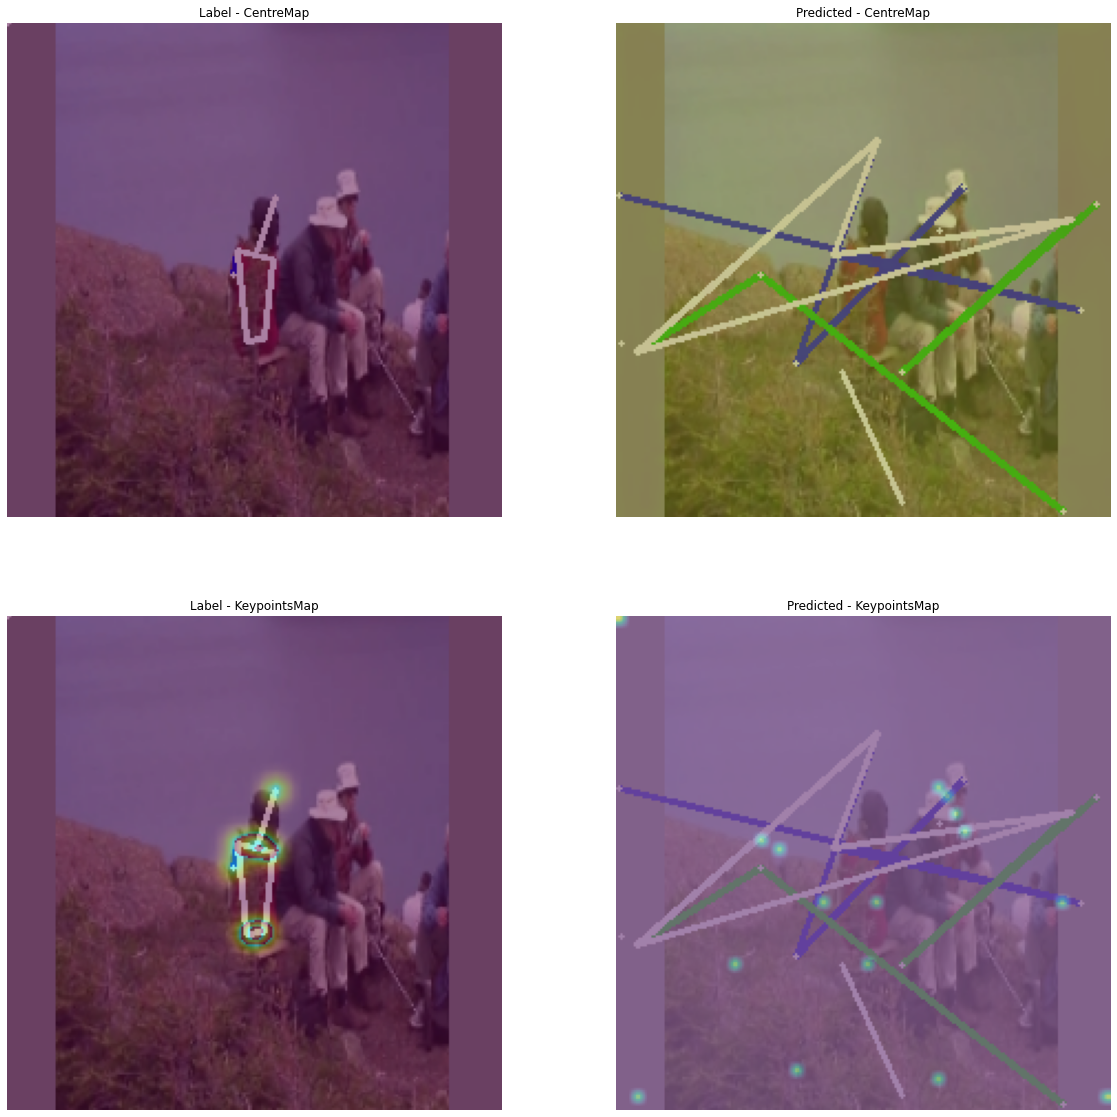

In [9]:
draw_sample(9)

In [10]:
print(Accuracy(y1, model(img)[0]))
print(avgMDE_2D(y1, model(img)[0]))

tf.Tensor(0.7, shape=(), dtype=float32)
tf.Tensor(0.29513428, shape=(), dtype=float32)


In [16]:
print(ClassificationLoss(y1, model(img)[0]))
print(RegrCoordsLoss(y1, model(img)[0]))

0.64812267
tf.Tensor(0.12602755, shape=(), dtype=float32)
